In [235]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [255]:
trip_start_date = '2018-07-02'
trip_end_date = '2018-07-08'

In [32]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()
last_date

[('2017-08-23')]

In [14]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [17]:
cols = inspector.get_columns('measurement')
for col in cols:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [150]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
          filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [153]:
prcp_df = df.groupby(df['Date']).sum()
prcp_df.head()

,Precipitation
Date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


<IPython.core.display.Javascript object>


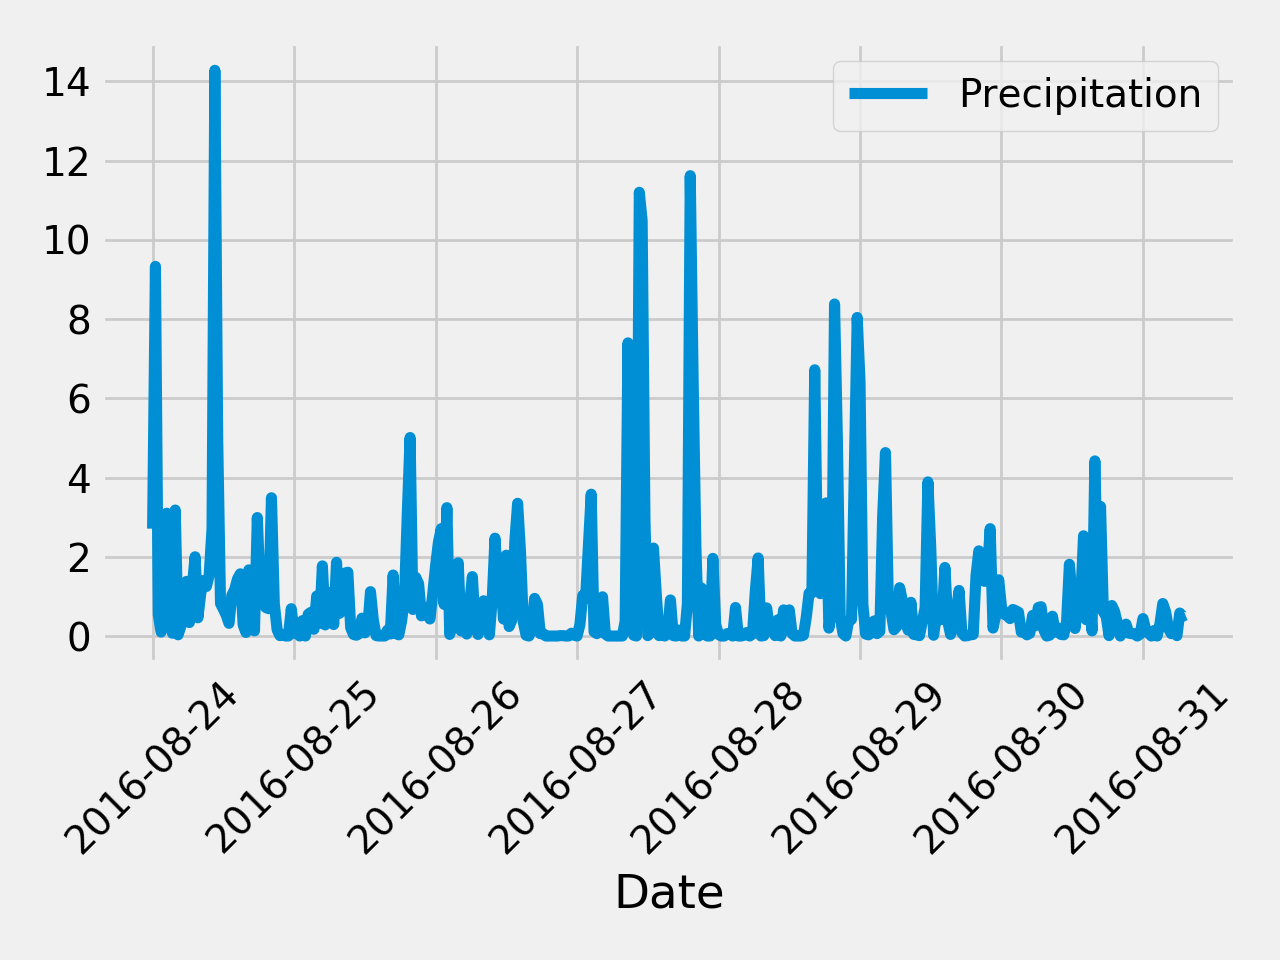

In [300]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_graph = prcp_df.plot()

# Rotate the xticks for the dates
prcp_graph.set_xticklabels(prcp_df.index, rotation=45)

plt.tight_layout()

In [156]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [60]:
# view columns in 'station' table
cols = inspector.get_columns('station')
for col in cols:
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [240]:
# view columns in 'measurement' table
cols = inspector.get_columns('measurement')
for col in cols:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [63]:
# How many stations are available in this dataset?
session.query(Station).group_by('station').count()
#session.query(Measurement).group_by('station').count()

9

In [82]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.date)).group_by('station').order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [194]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = active_stations[0][0]
sel = [Measurement.station, 
      func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]
session.query(*sel).filter(Measurement.station == most_active_station).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [297]:
temp_results = session.query(Measurement.tobs).\
          filter(Measurement.station == active_stations[0][0]).\
          filter(Measurement.date >= prev_year).all()
temp_results[:5]

[(77.0), (77.0), (80.0), (80.0), (75.0)]

<IPython.core.display.Javascript object>


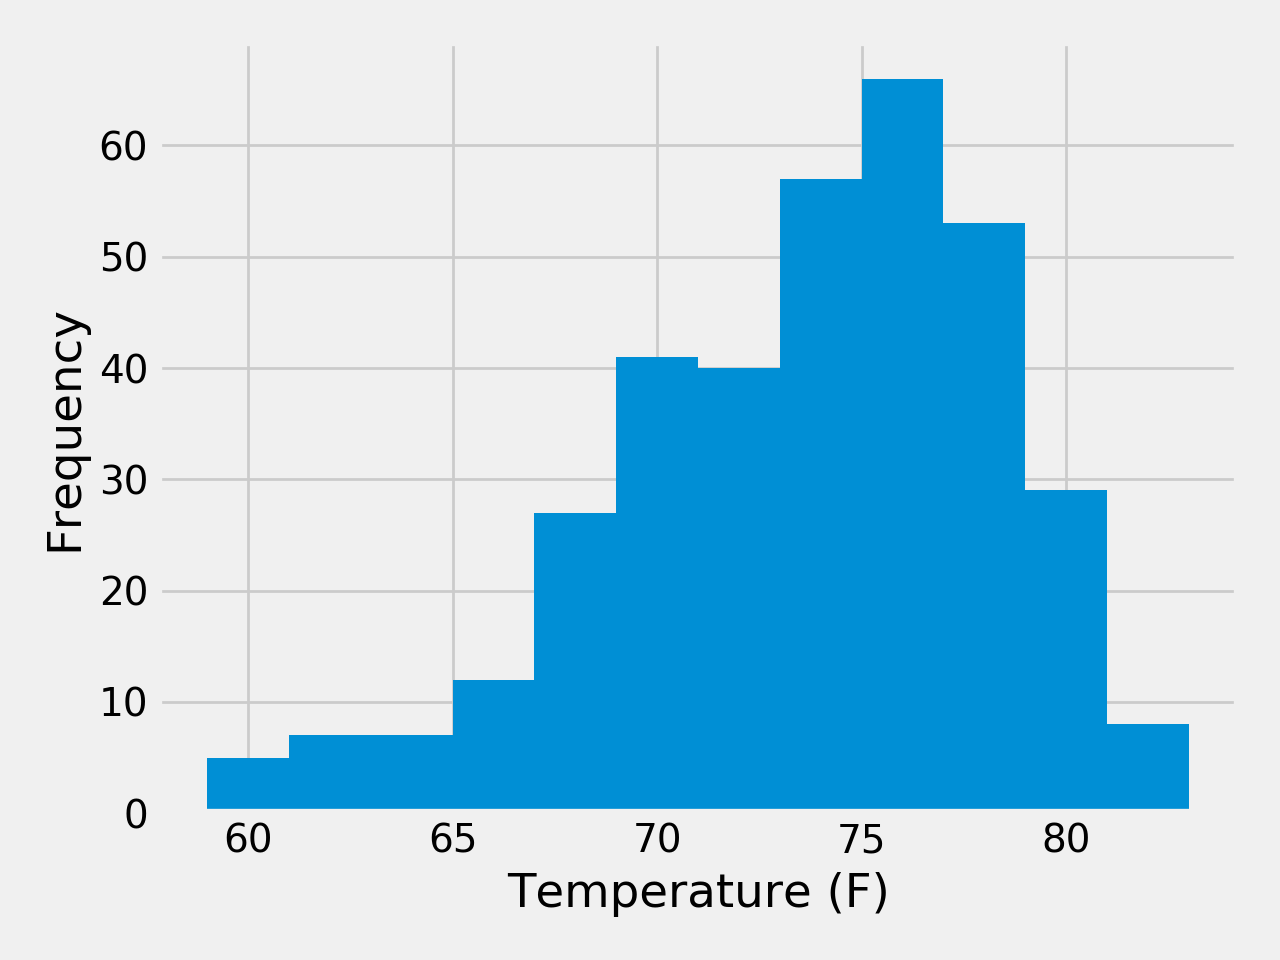

In [228]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_df = pd.DataFrame(temp_results, columns=['Temperature'])
temp_hist = temp_df.plot(kind='hist', bins=12, legend=False)
temp_hist.set_xlabel('Temperature (F)')
plt.tight_layout()

In [127]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [258]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
(tmin, tavg, tmax) = calc_temps('2017-07-02', '2017-07-07')
print(tmin, tavg, tmax)
#calc_temps('2016-08-23','2017-08-23')

74.0 78.27777777777777 87.0


In [260]:
t_df = pd.DataFrame({'tmin': tmin, 'tavg': tavg, 'tmax': tmax}, index=[0])
t_df

,tmin,tavg,tmax
0,74.0,78.277778,87.0


<IPython.core.display.Javascript object>


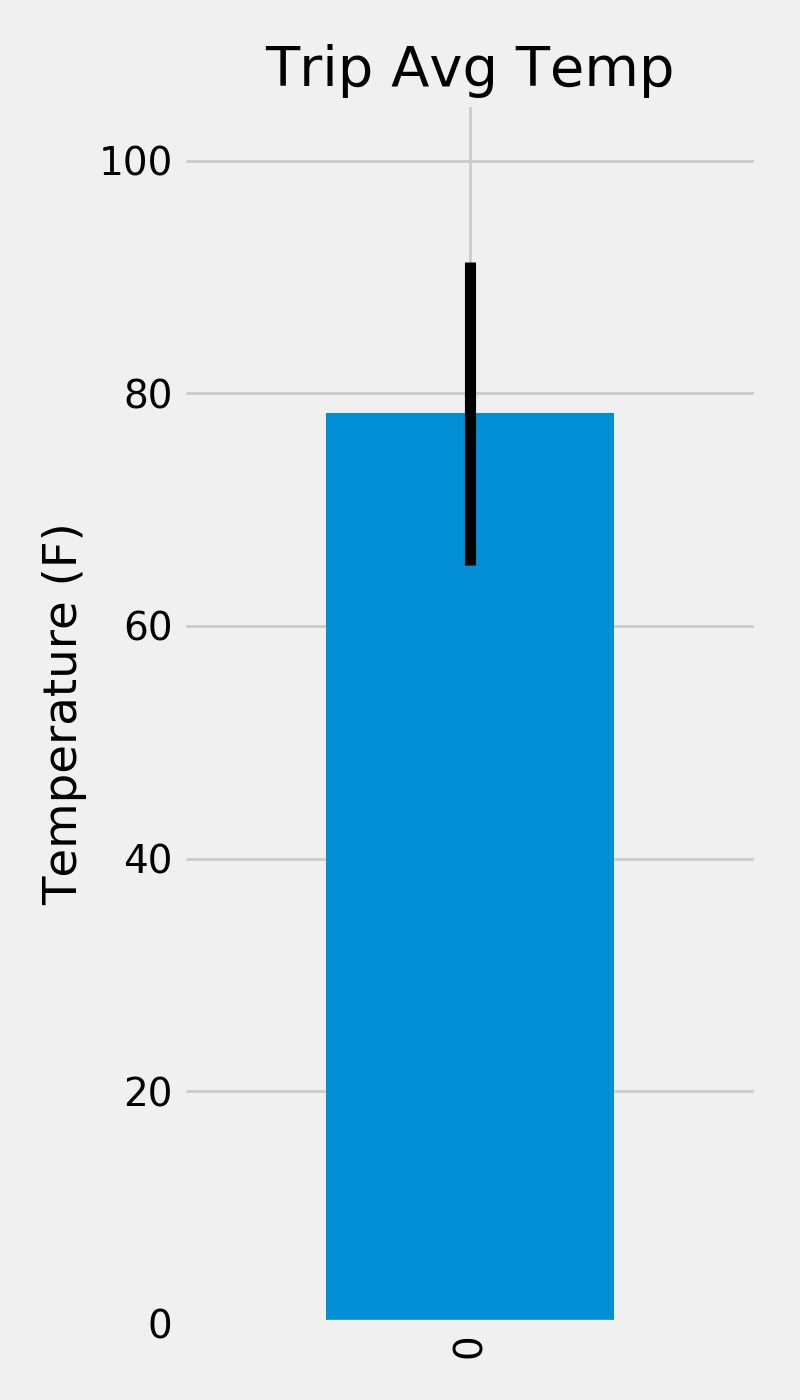

In [299]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_bar = t_df.plot(y='tavg',yerr=tmax-tmin,kind='bar', figsize=(4, 7), legend=False)
temp_bar.set_ylabel('Temperature (F)')
temp_bar.set_title('Trip Avg Temp')
temp_bar.set_ylim(0,105)
plt.tight_layout()

## Optional Challenge Assignment

In [238]:
# examine first 5 entries in 'measurement' table
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [239]:
# examine first 5 entires in 'station' table
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [269]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def find_station_prcp(start_date, end_date):
    """List of stations each containing STATION, NAME, LATITUDE, LONGITUDE, and ELEVATION for a particular date.
    
    Args:
        date (string): A date string in the format %Y-%m-%d
        
    Returns:
        STATION, NAME, LATITUDE, LONGITUDE, and ELEVATION for every station
    """
    sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
    return session.query(*sel).filter(Measurement.station == Station.station).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

find_station_prcp('2017-07-02', '2017-07-07')

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.22),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.56),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.22999999999999998),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.1),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.02),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  None),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

In [272]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [284]:
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
trip_range = pd.date_range(trip_start_date, trip_end_date)
trip_range

DatetimeIndex(['2018-07-02', '2018-07-03', '2018-07-04', '2018-07-05',
               '2018-07-06', '2018-07-07', '2018-07-08'],
              dtype='datetime64[ns]', freq='D')

In [286]:
# Strip off the year and save a list of %m-%d strings
trip_dates_md = []
for date in trip_range:
    trip_dates_md.append(date.strftime('%m-%d'))
trip_dates_md

['07-02', '07-03', '07-04', '07-05', '07-06', '07-07', '07-08']

In [288]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for trip_date_md in trip_dates_md:
    normals.append(list(np.ravel(daily_normals(trip_date_md))))
normals

[[68.0, 75.40384615384616, 82.0],
 [68.0, 75.32075471698113, 87.0],
 [70.0, 76.57142857142857, 81.0],
 [66.0, 75.0, 81.0],
 [69.0, 75.0, 81.0],
 [69.0, 74.91071428571429, 82.0],
 [69.0, 76.08333333333333, 83.0]]

In [289]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'], index=trip_range)
normals_df

,tmin,tavg,tmax
2018-07-02,68.0,75.403846,82.0
2018-07-03,68.0,75.320755,87.0
2018-07-04,70.0,76.571429,81.0
2018-07-05,66.0,75.000000,81.0
2018-07-06,69.0,75.000000,81.0
2018-07-07,69.0,74.910714,82.0
2018-07-08,69.0,76.083333,83.0


<IPython.core.display.Javascript object>


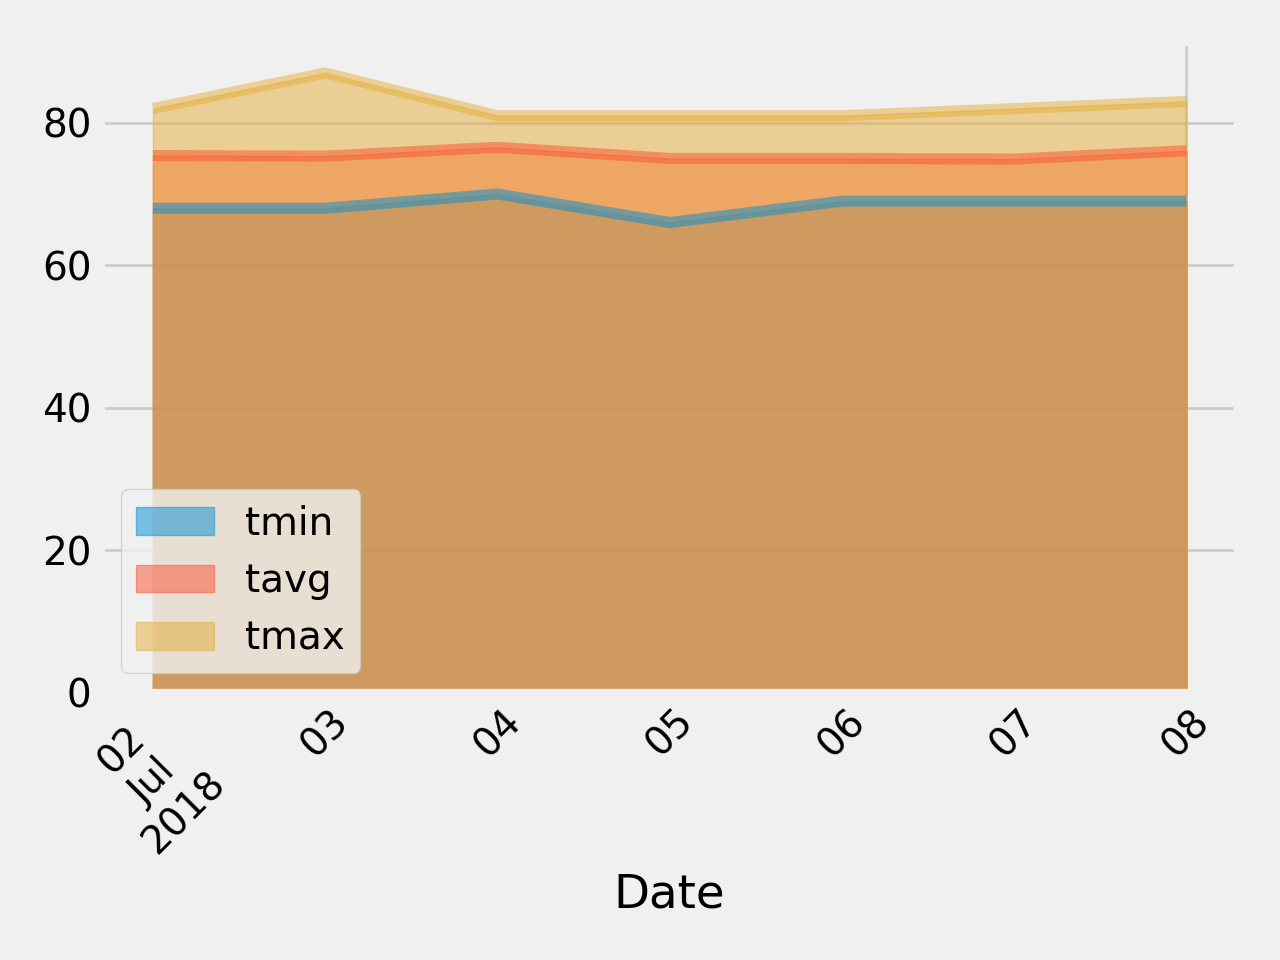

In [296]:
# Plot the daily normals as an area plot with `stacked=False`
normals_plot = normals_df.plot(kind='area', stacked=False, rot=45)
plt.xlabel('Date')
plt.tight_layout()
#normals_plot.set_xlabel('date')

### Flask API Testing

In [174]:
tobs = session.query(Measurement.date, Measurement.tobs).\
          filter(Measurement.date >= prev_year).all()
tobs

[('2016-08-23', 81.0),
 ('2016-08-24', 79.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 79.0),
 ('2016-08-27', 77.0),
 ('2016-08-28', 78.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 79.0),
 ('2016-08-31', 80.0),
 ('2016-09-01', 81.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 79.0),
 ('2016-09-04', 75.0),
 ('2016-09-05', 79.0),
 ('2016-09-06', 76.0),
 ('2016-09-07', 76.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 78.0),
 ('2016-09-11', 76.0),
 ('2016-09-12', 78.0),
 ('2016-09-13', 78.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 80.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 81.0),
 ('2016-09-19', 77.0),
 ('2016-09-20', 77.0),
 ('2016-09-21', 78.0),
 ('2016-09-22', 76.0),
 ('2016-09-23', 82.0),
 ('2016-09-24', 81.0),
 ('2016-09-25', 78.0),
 ('2016-09-26', 80.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 79.0),
 ('2016-09-29', 80.0),
 ('2016-09-30', 80.0),
 ('2016-10-01', 80.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

In [176]:
tobs_dict = {}
for tob in tobs:
    if tob[0] not in tobs_dict:
        tobs_dict[tob[0]] = [tob[1]]
    else: 
        tobs_dict[tob[0]].append(tob[1])
tobs_dict

{'2016-08-23': [81.0, 76.0, 80.0, 80.0, 80.0, 77.0, 74.0],
 '2016-08-24': [79.0, 76.0, 80.0, 78.0, 79.0, 77.0, 74.0],
 '2016-08-25': [80.0, 77.0, 81.0, 81.0, 80.0, 80.0, 77.0],
 '2016-08-26': [79.0, 78.0, 81.0, 81.0, 84.0, 80.0],
 '2016-08-27': [77.0, 73.0, 81.0, 81.0, 75.0, 74.0],
 '2016-08-28': [78.0, 73.0, 81.0, 80.0, 73.0, 71.0],
 '2016-08-29': [78.0, 78.0, 80.0, 80.0, 79.0, 78.0, 78.0],
 '2016-08-30': [79.0, 76.0, 79.0, 78.0, 77.0, 75.0],
 '2016-08-31': [80.0, 77.0, 80.0, 79.0, 78.0, 78.0, 76.0],
 '2016-09-01': [81.0, 79.0, 82.0, 82.0, 80.0, 77.0],
 '2016-09-02': [80.0, 78.0, 81.0, 81.0, 81.0, 80.0, 75.0],
 '2016-09-03': [79.0, 77.0, 78.0, 78.0, 75.0],
 '2016-09-04': [75.0, 75.0, 84.0, 78.0, 73.0],
 '2016-09-05': [79.0, 78.0, 82.0, 84.0, 78.0, 76.0],
 '2016-09-06': [76.0, 74.0, 80.0, 78.0, 73.0, 73.0],
 '2016-09-07': [76.0, 75.0, 80.0, 76.0, 74.0, 74.0],
 '2016-09-08': [80.0, 77.0, 81.0, 80.0, 79.0, 80.0, 74.0],
 '2016-09-09': [79.0, 76.0, 77.0, 79.0, 77.0, 79.0, 75.0],
 '2016-09-

In [180]:
prcp_list = []

prcps = session.query(Measurement.date, Measurement.prcp).\
          filter(Measurement.date >= prev_year).all()
          
for prcp in prcps:
    prcp_dict = {}
    prcp_dict['date'] = prcp[0]
    prcp_dict['prcp observations'] = [prcp[1]]
    prcp_dict['prcp observations'].append(prcp[1])
    prcp_list.append(prcp_dict)
prcp_list

[{'date': '2016-08-23', 'prcp observations': [0.0]},
 {'date': '2016-08-24', 'prcp observations': [0.08]},
 {'date': '2016-08-25', 'prcp observations': [0.08]},
 {'date': '2016-08-26', 'prcp observations': [0.0]},
 {'date': '2016-08-27', 'prcp observations': [0.0]},
 {'date': '2016-08-28', 'prcp observations': [0.01]},
 {'date': '2016-08-29', 'prcp observations': [0.0]},
 {'date': '2016-08-30', 'prcp observations': [0.0]},
 {'date': '2016-08-31', 'prcp observations': [0.13]},
 {'date': '2016-09-01', 'prcp observations': [0.0]},
 {'date': '2016-09-02', 'prcp observations': [0.0]},
 {'date': '2016-09-03', 'prcp observations': [0.0]},
 {'date': '2016-09-04', 'prcp observations': [0.03]},
 {'date': '2016-09-05', 'prcp observations': [None]},
 {'date': '2016-09-06', 'prcp observations': [None]},
 {'date': '2016-09-07', 'prcp observations': [0.05]},
 {'date': '2016-09-08', 'prcp observations': [0.0]},
 {'date': '2016-09-09', 'prcp observations': [0.03]},
 {'date': '2016-09-10', 'prcp observa

In [183]:
all_stations = session.query(Measurement.station).group_by('station').all()
all_stations = list(np.ravel(all_stations))
all_stations

['USC00511918',
 'USC00513117',
 'USC00514830',
 'USC00516128',
 'USC00517948',
 'USC00518838',
 'USC00519281',
 'USC00519397',
 'USC00519523']

In [186]:
results = session.query(Measurement.tobs).\
          filter(Measurement.date >= prev_year).all()
last_year_tobs = list(np.ravel(results))

[81.0,
 79.0,
 80.0,
 79.0,
 77.0,
 78.0,
 78.0,
 79.0,
 80.0,
 81.0,
 80.0,
 79.0,
 75.0,
 79.0,
 76.0,
 76.0,
 80.0,
 79.0,
 78.0,
 76.0,
 78.0,
 78.0,
 75.0,
 79.0,
 80.0,
 79.0,
 81.0,
 77.0,
 77.0,
 78.0,
 76.0,
 82.0,
 81.0,
 78.0,
 80.0,
 80.0,
 79.0,
 80.0,
 80.0,
 80.0,
 79.0,
 79.0,
 79.0,
 80.0,
 80.0,
 79.0,
 78.0,
 76.0,
 75.0,
 80.0,
 80.0,
 79.0,
 80.0,
 79.0,
 78.0,
 78.0,
 80.0,
 81.0,
 79.0,
 77.0,
 79.0,
 78.0,
 77.0,
 77.0,
 78.0,
 77.0,
 78.0,
 77.0,
 76.0,
 77.0,
 77.0,
 77.0,
 77.0,
 77.0,
 76.0,
 75.0,
 71.0,
 71.0,
 71.0,
 71.0,
 72.0,
 71.0,
 72.0,
 77.0,
 77.0,
 77.0,
 77.0,
 77.0,
 75.0,
 76.0,
 76.0,
 75.0,
 72.0,
 74.0,
 75.0,
 73.0,
 76.0,
 75.0,
 68.0,
 75.0,
 75.0,
 72.0,
 69.0,
 71.0,
 68.0,
 67.0,
 69.0,
 73.0,
 70.0,
 70.0,
 70.0,
 66.0,
 67.0,
 70.0,
 66.0,
 62.0,
 71.0,
 73.0,
 69.0,
 77.0,
 74.0,
 71.0,
 72.0,
 74.0,
 74.0,
 74.0,
 74.0,
 71.0,
 73.0,
 69.0,
 66.0,
 62.0,
 66.0,
 63.0,
 62.0,
 63.0,
 64.0,
 66.0,
 60.0,
 64.0,
 63.0,
 78.0,
 67.0,

In [193]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start, end='2017-08-23'):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start).filter(Measurement.date <= end).all()
    
    return list(np.ravel(results))
print(calc_temps('2012-02-28'))

[53.0, 73.43127438710152, 87.0]
